In [112]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from collections import Counter

from sklearn.metrics import roc_curve, confusion_matrix, classification_report

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.layers import InputLayer, Conv2D, Flatten, Dense, Dropout, MaxPool2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.applications import mobilenet_v2

In [74]:
def get_class_weights(y_true):

    counter = Counter(y_true)

    p = max(counter.values()) 
    for k in counter.keys():
        counter[k] += p

    majority = max(counter.values())

    return {cls: float(majority / count) for cls, count in counter.items()}

In [75]:
def plot_acc_loss(h):
    """
    Takes a history dictionary and plots accuracy and loss curves for
    train and validation datasets
    """
    
    acc, val_acc = h.history['accuracy'], h.history['val_accuracy']
    loss, val_loss = h.history['loss'], h.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [76]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [77]:
def print_cm(confmat):
    plt.figure(figsize=(7,7))
    sns.heatmap(confmat, annot=True, cmap='Blues', 
                square=True, fmt="d",
               xticklabels=test_generator.class_indices,
               yticklabels=test_generator.class_indices)
    plt.title("Confusion Matrix")
    plt.ylabel('Actual')
    plt.xlabel('Prediction');

#print_cm(confmat)

In [78]:
def create_model_cnn_multi(learning_rate = 0.001, activation = 'relu'):

    opt = Adam(learning_rate = learning_rate)

    model = Sequential()
    model.add(Conv2D(32, kernel_size = 3, input_shape = (224, 224, 3), activation = 'relu'))
    model.add(MaxPool2D())
    model.add(Conv2D(64, kernel_size = 3, activation = 'relu'))
    model.add(MaxPool2D())
    # Flatten the previous layer output
    model.add(Flatten())

    # Add as many outputs as classes with softmax activation
    model.add(Dense(5, activation = 'softmax'))
    
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [113]:
train_dir = '/Users/jmichit/Documents/Metis/projects/eye_disease/other/data-mclass/train'
test_dir = '/Users/jmichit/Documents/Metis/projects/eye_disease/other/data-mclass/test'

train_datagen = ImageDataGenerator(#rescale = 1. /255, 
                                   preprocessing_function=mobilenet_v2.preprocess_input)

train_datagen_aug = ImageDataGenerator(#rescale = 1. /255,
                                  rotation_range = 40,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,
                                  preprocessing_function=mobilenet_v2.preprocess_input)

test_datagen = ImageDataGenerator(#rescale = 1. /255,
                                  preprocessing_function=mobilenet_v2.preprocess_input)

size = (224, 224)
batch_size = 32

train_generator = train_datagen.flow_from_directory(
                    train_dir,
                    target_size=size,
                    batch_size = batch_size,
                    class_mode='categorical',
                    shuffle=True)

train_generator_aug = train_datagen_aug.flow_from_directory(
                    train_dir,
                    target_size=size,
                    batch_size = batch_size,
                    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
                    test_dir,
                    target_size=size,
                    batch_size = batch_size,
                    class_mode='categorical',
                    shuffle=False)

Found 1223 images belonging to 5 classes.
Found 1223 images belonging to 5 classes.
Found 1220 images belonging to 5 classes.


In [114]:
# note we exclude the final dense layers by setting include_top=False,
# and add new ones to train from scratch below
base_model = mobilenet_v2.MobileNetV2(weights='imagenet', 
                                      include_top=False, 
                                      input_shape=(224,224,3)) 
 
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False    

# Establish new fully connected block
x = base_model.output
x = Flatten()(x) # flatten from convolution tensor output 
x = Dense(200, activation='relu')(x) #100
#x = Dropout(0.5)(x)
x = Dense(200, activation='relu')(x) #100
#x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(100, activation='relu')(x) #100
x = Dropout(0.2)(x)
x = Dense(50, activation='relu')(x)  #50
predictions = Dense(5, activation='softmax')(x) # should match # of classes predicted

# define formal model object to train and compile it as usual
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_14[0][0]                   
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
___________________________________________________________________________________________

In [115]:
modelcheck = ModelCheckpoint("multi_cnn_aug_pre:{epoch:02d}-{val_loss:.2f}.h5",
                             monitor='val_loss',
                            save_best_only = True)

estop = EarlyStopping(monitor="val_loss",
                      patience = 4)

STEP_SIZE_TRAIN = train_generator_aug.n // train_generator_aug.batch_size
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size

In [116]:
# model = create_model_cnn_multi()
# model.summary()

In [117]:
# address imbalance sample size
# class_weights = {'Mild': 0, 
#                  'Moderate': 1, 
#                  'No_DR': 2, 
#                   'Proliferate_DR': 3,
#                  'Severe': 4}


history = model.fit(
        train_generator_aug,
        steps_per_epoch = STEP_SIZE_TRAIN,
        epochs = 20,
        validation_data = test_generator,
        validation_steps = STEP_SIZE_TEST,
        callbacks=[estop, modelcheck],
        class_weight = get_class_weights(train_generator.classes)
        )

Epoch 1/20
38/38 [==============================] - 54s 1s/step - loss: 1.8287 - accuracy: 0.4821 - val_loss: 3.2741 - val_accuracy: 0.3183
Epoch 2/20
38/38 [==============================] - 44s 1s/step - loss: 1.1388 - accuracy: 0.7113 - val_loss: 0.8590 - val_accuracy: 0.6916
Epoch 3/20
38/38 [==============================] - 45s 1s/step - loss: 1.0856 - accuracy: 0.7113 - val_loss: 0.8951 - val_accuracy: 0.7385
Epoch 4/20
38/38 [==============================] - 47s 1s/step - loss: 1.0828 - accuracy: 0.7176 - val_loss: 1.3118 - val_accuracy: 0.6513
Epoch 5/20
38/38 [==============================] - 44s 1s/step - loss: 0.9727 - accuracy: 0.7494 - val_loss: 0.6965 - val_accuracy: 0.7484
Epoch 6/20
38/38 [==============================] - 44s 1s/step - loss: 0.9108 - accuracy: 0.7694 - val_loss: 1.1324 - val_accuracy: 0.6678
Epoch 7/20
38/38 [==============================] - 44s 1s/step - loss: 0.9112 - accuracy: 0.7732 - val_loss: 0.7065 - val_accuracy: 0.7525
Epoch 8/20
38/38 [==

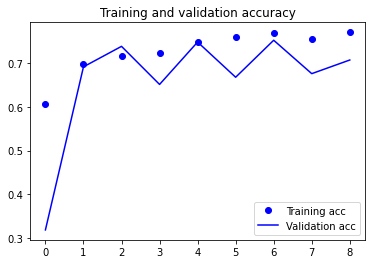

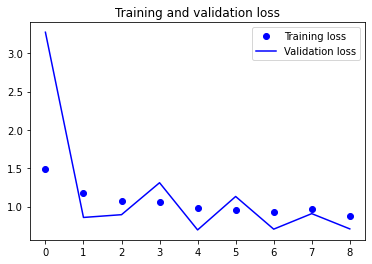

In [118]:
plot_acc_loss(history)

In [119]:
num_of_test_samples = test_generator.n


Y_pred = model.predict(x=test_generator, steps=len(test_generator) )
y_pred = np.argmax(Y_pred, axis=1)

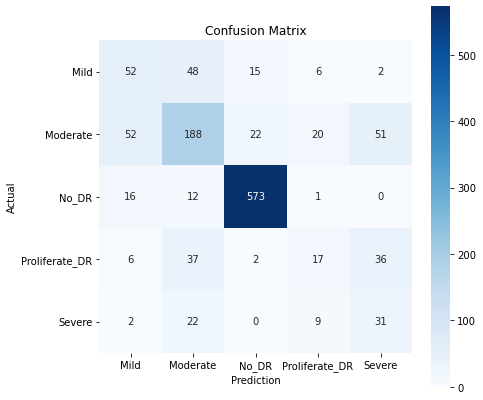

In [120]:
confmat = confusion_matrix(test_generator.classes, y_pred)

print_cm(confmat)

In [16]:
pd.DataFrame({'class' : train_generator.classes}).value_counts() 

class
2        602
1        333
0        124
3         99
4         65
dtype: int64

In [17]:
get_class_weights(train_generator.classes)

{0: 1.6584022038567494,
 1: 1.2877005347593582,
 2: 1.0,
 3: 1.717546362339515,
 4: 1.8050974512743627}

In [18]:
from sklearn.metrics import accuracy_score
accuracy_score(test_generator.classes, y_pred)

0.4934426229508197

In [22]:
imgs, labels = next(train_generator)

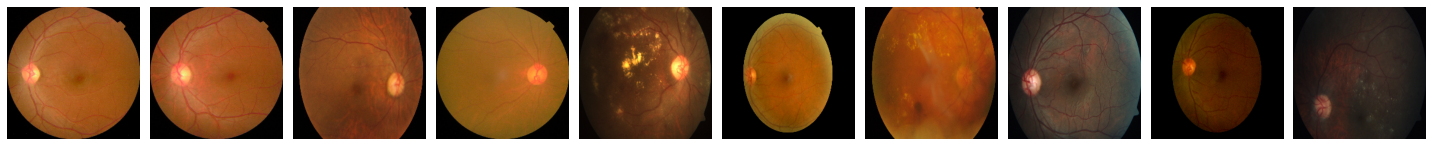

[[0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]]


In [23]:
plotImages(imgs)
print(labels)

In [24]:
train_generator.class_indices

{'Mild': 0, 'Moderate': 1, 'No_DR': 2, 'Proliferate_DR': 3, 'Severe': 4}

In [25]:
pwd


'/Users/jmichit/Documents/Metis/projects/eye_disease/other'

In [121]:

base_model_all = mobilenet_v2.MobileNetV2(weights='imagenet', 
                                      include_top=True, 
                                      input_shape=(224,224,3)) 